In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import math
import warnings
warnings.filterwarnings("ignore")

In [55]:
ticker_symbol = 'ETH-USD'
start_date = '2018-01-01'
end_date = '2024-01-01'

data = yf.download(ticker_symbol, start=start_date, end=end_date)
data.reset_index(inplace=True)
data.head()

[*********************100%%**********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-01,755.757019,782.530029,742.004028,772.640991,772.640991,2595760128
1,2018-01-02,772.346008,914.830017,772.346008,884.443970,884.443970,5783349760
2,2018-01-03,886.000000,974.471008,868.450989,962.719971,962.719971,5093159936
3,2018-01-04,961.713013,1045.079956,946.085999,980.921997,980.921997,6502859776
4,2018-01-05,975.750000,1075.390015,956.325012,997.719971,997.719971,6683149824


In [56]:
def get_indicator(data, period_ibs, period_roc, period_rvol):
    data['IBS'] = (data['Close']-data['Low'])/(data['High']-data['Low'])
    data['IBS_weight_avg'] = data['IBS'].ewm(span=period_ibs, adjust=False).mean()

    data['ROC'] = (data['Close']/data['Close'].shift(period_roc))

    data['Vol_rolling_mean'] = data['Volume'].rolling(period_rvol).mean()
    data['RVOL'] = (data['Volume']/data['Vol_rolling_mean'])

    data['Indicator'] = data['RVOL'] + data['ROC'] + data['IBS_weight_avg']
    return data

In [69]:
def get_list(data, sl, tp):
  buy_list = []
  sell_list = []

  i = 2
  while (i < len(data)):

    trade = False
    trend = data.loc [i, 'Trend']

    if ((trend == 1) and (trade == False)):
      buy_price = data.loc[i, 'Close']
      stop_loss = buy_price*( 1 - sl )
      take_profit = buy_price*( 1 + tp )
      buy_list.append(i)
      trade = True

    while ((trade == True) and (i < len(data)-1)):
      latest_close = data.loc[i, 'Close']
      trend = data.loc [i, 'Trend']
      if ((trend == 0) or (take_profit < latest_close) or (stop_loss > latest_close)):
        trade = False
        sell_list.append(i)
      else:
        i = i + 1
    i = i + 1

  return buy_list, sell_list

def generate_signals(data):
  data['Trend'] = 0

  for i in range(len(data)):
    if(data['Indicator'][i] > 2.8) :
      data['Trend'][i] = 1
    elif(data['Indicator'][i] < 2.3):
      data['Trend'][i] = 0

  return data

# Used to calculate maximum drawdown
def max_dd(lst):
    start = end = 0
    min_sum = float('inf')
    min_sublist = []

    while end < len(lst):
        sub_sum = sum(lst[start:end+1])
        if sub_sum < min_sum:
            min_sum = sub_sum
            min_sublist = lst[start:end+1]
        end += 1

        while start < end and sub_sum >= min_sum:
            sub_sum -= lst[start]
            start += 1

    return sum(min_sublist)

def analytics(data, buy_list, sell_list):
  len_trades = len(buy_list)
  pnl_list = []
  returns_list = []
  cpnl_list = []
  pnl = 0
  profit_trades = 0
  loss_trades = 0
  profit = 0
  loss = 0
  pnlp = 0
  max_loss = 0
  rfr = 0.04
  balance = 100000

  for i in range(len_trades-1):
    buy_index = buy_list[i]
    sell_index = sell_list[i]
    pnlt = data.loc[sell_index, 'Close'] - data.loc[buy_index, 'Close']
    balance += balance*pnlt/data.loc[buy_index, 'Close']
    pnlp = pnlp + pnlt*100/data.loc[buy_index, 'Close']
    pnl = pnl + pnlt
    cpnl_list.append(pnl)
    pnl_list.append(pnlt)
    returns_list.append(pnlp)
    if (pnlt > 0):
      profit_trades = profit_trades+1
      profit = profit + pnlt
    else:
      loss_trades = loss_trades+1
      loss = loss + pnlt
      if (pnlt < max_loss):
        max_loss = pnlt

# Calculation of Sharpe Ratio
  sharpe = math.sqrt(252)*((np.mean(returns_list)-rfr)/np.std(returns_list))

# Calculation of Sortino Ratio
  negative_returns = [r for r in returns_list if r < rfr]
  downside_risk = np.std(negative_returns)
  sortino = (np.mean(returns_list) - rfr) / downside_risk

  print(f'Net portfolio value is: {balance}')
  print(f'Net profit is: {balance-100000}')
  print(f'Net percentage return is: {balance/1000-100} %')
  print(f'Total number of trades is: {len_trades}')
  print(f'Number of winning trades is: {profit_trades}')
  print(f'Number of losing trades is: {loss_trades}')
  print(f'Average profit per winning trade is: {profit/profit_trades}')
  print(f'Average loss per losing trade is: {loss/loss_trades}')
  print(f'Maximum Drawdown is: {max_dd(returns_list)} %')
  print(f'Sharpe Ratio of the strategy is: {sharpe}')
  print(f'Sortino Ratio of the strategy is: {sortino}')

In [70]:
data = get_indicator(data, 5, 3, 14)
data = generate_signals(data)
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,IBS,IBS_weight_avg,ROC,Vol_rolling_mean,RVOL,Indicator,Trend
0,2018-01-01,755.757019,782.530029,742.004028,772.640991,772.640991,2595760128,0.755983,0.755983,NaN,NaN,NaN,NaN,0
1,2018-01-02,772.346008,914.830017,772.346008,884.443970,884.443970,5783349760,0.786741,0.766235,NaN,NaN,NaN,NaN,0
2,2018-01-03,886.000000,974.471008,868.450989,962.719971,962.719971,5093159936,0.889162,0.807211,NaN,NaN,NaN,NaN,0
3,2018-01-04,961.713013,1045.079956,946.085999,980.921997,980.921997,6502859776,0.351900,0.655441,1.269570,NaN,NaN,NaN,0
4,2018-01-05,975.750000,1075.390015,956.325012,997.719971,997.719971,6683149824,0.347667,0.552849,1.128076,NaN,NaN,NaN,0


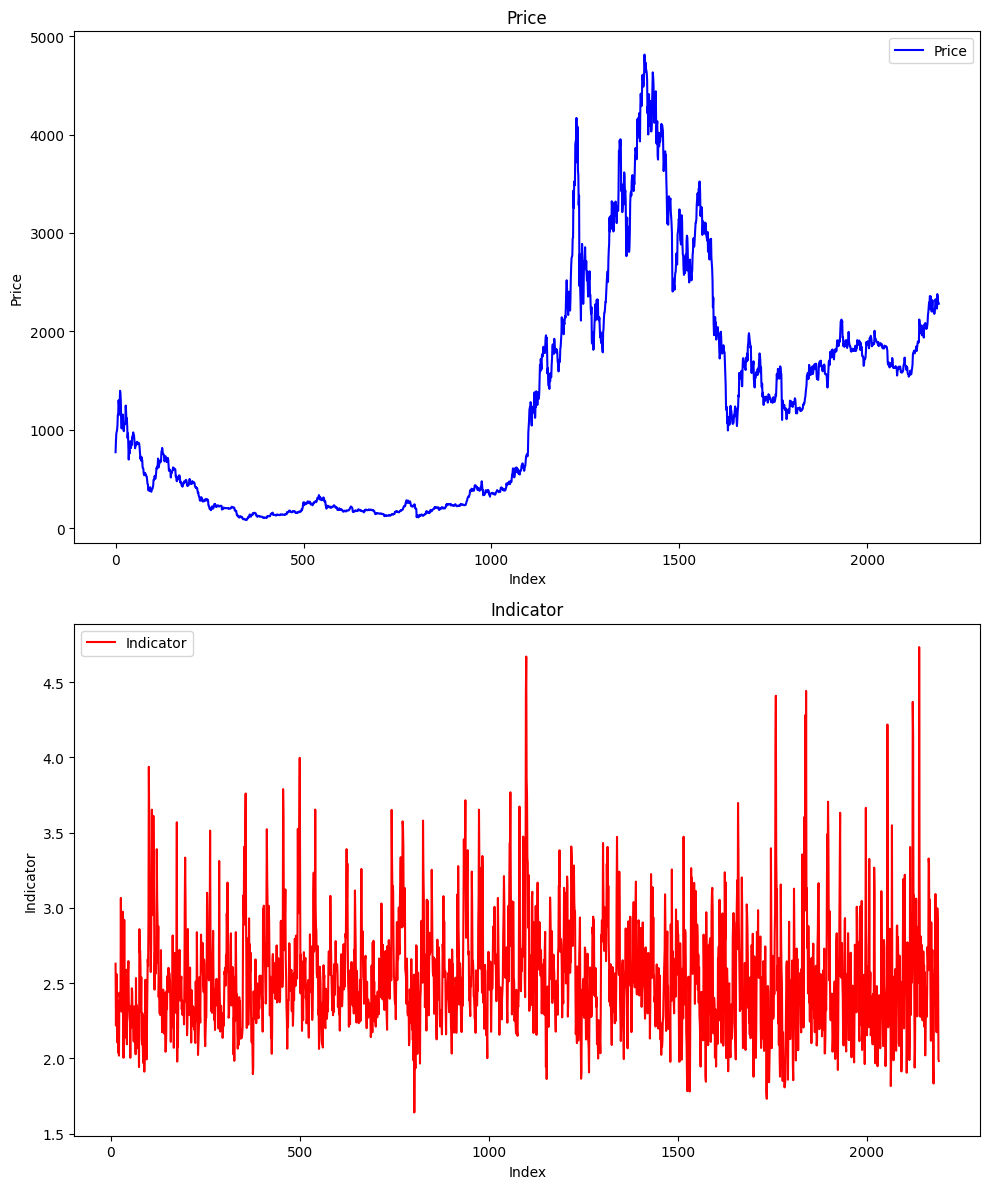

In [71]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

ax1.plot(data['Close'], color='blue', label='Price')
ax1.set_title('Price')
ax1.set_xlabel('Index')
ax1.set_ylabel('Price')
ax1.legend()

ax2.plot(data['Indicator'], color='red', label='Indicator')
ax2.set_title('Indicator')
ax2.set_xlabel('Index')
ax2.set_ylabel('Indicator')
ax2.legend()

fig.tight_layout()
plt.show()


In [72]:
buy_list, sell_list = get_list(data, 0.1, 0.1)
analytics(data, buy_list, sell_list)

Net portfolio value is: 634193.0396272733
Net profit is: 534193.0396272733
Net percentage return is: 534.1930396272734 %
Total number of trades is: 203
Number of winning trades is: 104
Number of losing trades is: 98
Average profit per winning trade is: 62.950185995835525
Average loss per losing trade is: -47.71192426097636
Maximum Drawdown is: -9.257714050246435 %
Sharpe Ratio of the strategy is: 24.981780796577755
Sortino Ratio of the strategy is: 43.259618332625074
